In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib import cm
# cosmology
from astropy.cosmology import Planck18 as Planck
import astropy.units as u
from astropy.cosmology import z_at_value
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

In [2]:
zMIN = 0
zMAX = 40

In [3]:
# considered models
#models = ['A-sloth', 'Hartwig16', 'DeSouza', 'Jaacks', 'LiuBromm', 'MandF2017']
models = ['A-sloth_smooth_off', 'DeSouza_smooth_off', 'Jaacks', 'LiuBromm']


models_leg = ['H22', 'dS11', 'J19', 'LB20']

pop = 'III'



viridis = cm.get_cmap('viridis', len(models))
divid = np.linspace(0, 1,len(models))
color_models = viridis(divid)#[::-1]

In [4]:
def select_SFR_model(SFRD_model, pop):
    if pop == 'III':
        # select the popIII star formation rate density model
        # models: asloth, hartwig16,desouza,jaacks
        # other possible model 'LiuBromm'

        if SFRD_model == 'A-sloth':
            sfrd_interpol_file = 'asloth_popIII_z_cSFR.dat'
            SFRD_save = 'asloth'
            at_z_0 = False

        elif SFRD_model == 'Hartwig16':
            sfrd_interpol_file = 'Hartwig_2016.txt'
            SFRD_save = 'hartwig16'
            at_z_0 = False

        elif SFRD_model == 'DeSouza':
            sfrd_interpol_file = 'De_Souza_point.txt'
            SFRD_save = 'desouza'
            at_z_0 = False

        elif SFRD_model == 'Jaacks':
            sfrd_interpol_file = 'Jaacks_point.txt'
            SFRD_save = 'jaacks'
            at_z_0 = False
            
        elif SFRD_model == 'Jaacks_refined':
            sfrd_interpol_file = 'PopIII_SFRD_Jaacks19_refined.txt'
            SFRD_save = 'jaacks_refined'
            at_z_0 = False
            
        elif SFRD_model == 'PopII_A-sloth_smooth_off':
            sfrd_interpol_file = 'asloth_popII_z_cSFR.dat'
            SFRD_save = 'PopII_asloth_smooth_off'
            at_z_0 = False

        elif SFRD_model == 'LiuBromm':
            sfrd_interpol_file = False
            SFRD_save = 'LiuBromm' #SFRD_model
            #############
            at_z_0 = None
        
    
        elif SFRD_model == 'Skinner':
            sfrd_interpol_file = 'skinner_point.txt'
            SFRD_save = 'SW20' #SFRD_model
            at_z_0 = False
            
            


        # in these two cases we extrapolate the SFR at redshift zero
        elif SFRD_model == 'A-sloth_smooth_off':
            sfrd_interpol_file = 'asloth_popIII_z_cSFR.dat'
            SFRD_save = 'asloth_smooth_off'
            at_z_0 = True
            
            
        elif SFRD_model == 'A-sloth_smooth_off_med':
            sfrd_interpol_file = 'asloth_popIII_z_cSFR_median.dat'
            SFRD_save = 'asloth_smooth_off_med'
            at_z_0 = True
        
        elif SFRD_model == 'A-sloth_smooth_off_low':
            sfrd_interpol_file = 'asloth_popIII_z_cSFR_2.5perc.dat'
            SFRD_save = 'asloth_smooth_off_low'
            at_z_0 = True
            
        elif SFRD_model == 'A-sloth_smooth_off_high':
            sfrd_interpol_file = 'asloth_popIII_z_cSFR_97.5perc.dat'
            SFRD_save = 'asloth_smooth_off_high'
            at_z_0 = True
            
        elif SFRD_model == 'DeSouza_smooth_off':
            sfrd_interpol_file = 'De_Souza_point.txt'
            SFRD_save = 'desouza_smooth_off'
            at_z_0 = True
            
        elif SFRD_model == 'Skinner_smooth_off':
            sfrd_interpol_file = 'skinner_point.txt'
            SFRD_save = 'SW20_smooth_off' #SFRD_model
            at_z_0 = True

    
        elif SFRD_model == 'MandF2017':
            print('This SFR density model is for popI-II stars!')
            raise

    elif pop == 'I-II':

        sfr_avg = -2  # from Madau & Dickinson 2017, normalisation value
        # select the popII star formation rate density model
        SFRD_save = SFRD_model
        sfrd_interpol_file = False 
        if SFRD_model != 'MandF2017': # single option 
            print("Error, wrong popI-II SFR model")
            raise
    
            
    return  sfrd_interpol_file, at_z_0

In [5]:
def SFR_build(SFRD_model, pop, sfrd_interpol_file, at_z_0):

    if pop == 'III':

        if sfrd_interpol_file == False:

            # compute star formation rate in Msun yr-1 Mpc-3 (model LiuBromm)
            if SFRD_model=='LiuBromm':
                sfr_args_chosen = None
                def SFR_eval(z_form, sfr_args):
                    SFR_at_z = 765.7*(1. + z_form)**(-5.9) / (1.+((1. + z_form)/12.8)**(-8.5))  # Msun yr-1 Mpc-3
                    return SFR_at_z

                # minimum lookback time at which SFR potentially can happen
                # this will be used in creating the catalogs 
                t_min = Planck.lookback_time(0)/u.Gyr*1e9 #in yr


                ########
                z_fromtxt = None
                sfr_fromtxt = None

        # SFRD can also be found via interpolation
        elif sfrd_interpol_file != False:

            is_sorted = lambda a: np.all(a[:-1] <= a[1:])

            # read the SFRD model from file 
            z_fromtxt, sfr_fromtxt = np.genfromtxt('../'+sfrd_interpol_file, 
                                                   dtype='float', unpack=True)

            # z_fromtxt must be given in descending order -> checked
            if is_sorted(z_fromtxt) != True:
                print('redshift array is not properly sorted')
                raise

            #if at_z_0 == False:
                # first point present in the txt and also minimum redshift 
                # at which SFR happens 
                # at z<z_min we assume sfrd=0 (usefull e.g. in jaacks)
            #    z_fromtxt_first=z_fromtxt[0] 


                # minimum time at which SFR happens 
                # this will be used in creating the catalogs 
            #    t_min = Planck.lookback_time(z_fromtxt_first)/u.Gyr*1e9 #in yr
                #print('minimum time = ', t_min, 'yr')
            #elif at_z_0 == True:
                # first point present in the txt and also minimum redshift 
                # at which SFR happens 
                # at z<z_min we assume sfrd=0 (usefull e.g. in jaacks)
            #    z_fromtxt_first=0 
                # minimum time at which SFR happens 
                # this will be used in creating the catalogs 
            #    t_min = Planck.lookback_time(z_fromtxt_first)/u.Gyr*1e9 #in yr
            #    #print('minimum time = ', t_min, 'yr')

            ## we extrapolate the SFR at redshift zero
            #if at_z_0 == True:
                #first two points in the txt
                #these will be used to perform linear extrapolation at z < z_min
            #    if SFRD_model=='Skinner_smooth_off':
            #        ind_to_be = 0
            #    elif SFRD_model=='PopII_A-sloth_smooth_off':
            #        ind_to_be = 2
            #    else:
            #        ind_to_be = 1

            #    z_fromtxt_first = z_fromtxt[ind_to_be]
            #    z_fromtxt_first2= z_fromtxt[ind_to_be+1] 
            #    sfr_fromtxt_first = np.log10(sfr_fromtxt[ind_to_be])
            #    sfr_fromtxt_first2 = np.log10(sfr_fromtxt[ind_to_be+1])




            ##last two points  in the txt
            ## these will be used to perform linear extrapolation at z > z_max
            #z_fromtxt_last, z_fromtxt_last2=z_fromtxt[-1], z_fromtxt[-2] 
            #sfr_fromtxt_last, sfr_fromtxt_last2=sfr_fromtxt[-1], sfr_fromtxt[-2]



            # perform interpolation 
            #SFR_at_z_interp1d =  interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
            #                             fill_value='extrapolate')
            
            # perform interpolation 
            SFR_at_z_interp1d =  interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
                                     fill_value=(0,0))
            
            
            sfr_args_chosen = SFR_at_z_interp1d


            def SFR_eval(z_form, sfr_args):

                # explicitely tell the code what to do for each redshift bin
                #if z_form < z_fromtxt_first:

                #    if at_z_0 == False:
                        #here I am forcely switching off the SFR
                #        SFR_at_z = 0.0
                        #print(z_form,SFR_at_z)

                #    elif at_z_0 == True:

                #        coeff_m=(sfr_fromtxt_first - sfr_fromtxt_first2)/(z_fromtxt_first - z_fromtxt_first2)
                #        coeff_b=sfr_fromtxt_first-(coeff_m*z_fromtxt_first)
                #        SFR_at_z=10**(coeff_m*z_form+coeff_b)

                        #SFR_at_z = sfr_args(z_form)

                #        if (SFR_at_z<0.0):
                #            print('SFR < 0 at z =', z_form, '< z_min =', z_fromtxt_first)

                            # I can either put it to zero 
                            # or to a very low constant value like the least available bin

                #            SFR_at_z=0.0




                            #SFR_at_z=sfr_fromtxt[0]



                #if we sample at z higher than last point in txt, we assume SFRD to follow the slope of the last 2 point in the txt
                #elif z_form > z_fromtxt_last:

                #    coeff_m=(sfr_fromtxt_last - sfr_fromtxt_last2)/(z_fromtxt_last - z_fromtxt_last2)
                #    coeff_b=sfr_fromtxt_last-(coeff_m*z_fromtxt_last)
                #    SFR_at_z=coeff_m*z_form+coeff_b

                    #SFR_at_z = sfr_args(z_form)

                #    if (SFR_at_z<0.0):
                        #print('Error, SFR less than 0')
                #        SFR_at_z=0.0
                 #if is it is inside the range we interpolate the point via cubic spline interpolation.
                #else:
                    # here is simple interpolation
                #    SFR_at_z = sfr_args(z_form)
                
                SFR_at_z = sfr_args(z_form)


                return SFR_at_z

    return SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt


A-sloth_smooth_off
DeSouza_smooth_off
Jaacks
LiuBromm


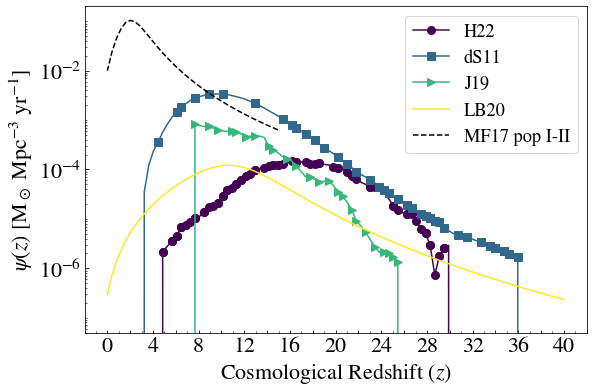

In [6]:
# let's compare the variosu SFRD 

font_value = 22
#plt.figure(figsize=(9,6))

fig, axs = plt.subplots(1,1,figsize=(9,6),gridspec_kw={
                         'wspace': 0, 'hspace': 0})  

z_sfr = np.linspace(zMAX,zMIN,100)

marker_sfrd = ['o','s','>','<']

m = 0
for mod in models:
    print(mod)
    
    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


        
    if (sfrd_interpol_file == False) and (mod != 'MandF2017'): 
        
        p = axs.plot(z_sfr, SFR_array,
                 label = models_leg[m],
                    color = color_models[m],
                    )
        np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        
        
    else:
        
        markers_on  = []
        for tt in range(len(sfr_fromtxt)):
            markers_on.append(np.argmin(abs(sfr_fromtxt[tt]-SFR_array)))
            
            
    
        if at_z_0 == True:
        
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg[m], linestyle = 'solid',
                    color = color_models[m],
                     marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        


        else:
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg[m],
                    color = color_models[m],
                    marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
        
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
    
    
                #,color = color_z[m+1])
    #color_p = p[0].get_color()

    #if (sfrd_interpol_file != False) and (mod != 'MandF2017'): 
    #    axs.plot(z_fromtxt, sfr_fromtxt, linewidth = 0, marker = marker_sfrd[m], color = color_p,
    #            markersize = 8)
                    #,label = sfrd_interpol_file)

            
        
            
    m += 1 

    
def  SFR_at_z(z_form):
    
    sfr_norm_in_f = 1e-2
    
    sfr = sfr_norm_in_f*(1. + z_form)**(2.6) / \
                (1.+((1. + z_form)/3.2)**(6.2))  # Msun yr-1 Mpc-3)
    
    return sfr

ind_z = z_sfr < 15

axs.plot(z_sfr[ind_z], SFR_at_z(z_sfr[ind_z]), color = 'black',
         linestyle = 'dashed',label = 'MF17 pop I-II')        
    

    
axs.set_ylim(bottom = 5e-8, top = 2e-1)
axs.set_xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
axs.set_ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)
axs.set_yscale('log')
#plt.ylim(bottom = 1e-9)
axs.tick_params(axis='both', which='both', labelsize=font_value, direction = 'in')

axs.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40])
axs.set_xticklabels(['0','','4','','8','','12','','16','','20','','24','','28','','32','','36','','40'])


axs.xaxis.set_minor_locator(ticker.MultipleLocator(1))

## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs.yaxis.set_minor_locator(y_minor)
axs.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#axs.plot(-1,1e-20, linewidth = 0, marker = 'o', label = 'Interpolation points', color = 'black')

plt.legend(fontsize = font_value/1.2, ncol = 1, loc = 1)

#ax2 = axs.twiny()
#ax2.tick_params(axis='both', which='both', direction='out',length=0, labelsize = 0)
#l0 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0, marker = 'o', alpha = 1)
#l1 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0)
#ax2.legend((l0,l1),('Interpolation points',''),
#               fontsize=font_value, 
#               loc='upper right', ncol=1)


plt.savefig('SFRD_comparison.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()

A-sloth_smooth_off
DeSouza_smooth_off
Jaacks
LiuBromm


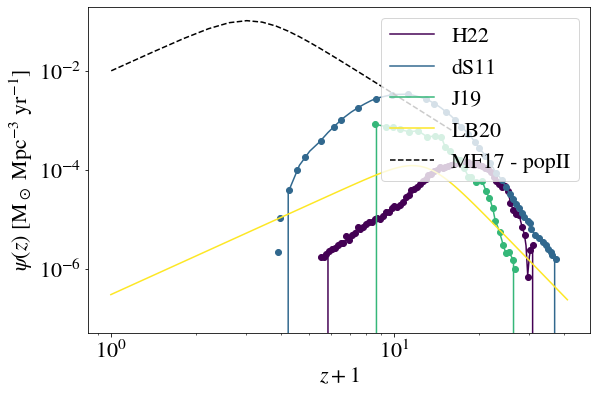

In [7]:
# let's compare the variosu SFRD 

font_value = 22
plt.figure(figsize=(9,6))
z_sfr = np.linspace(zMAX,zMIN,100)

m = 0
for mod in models:
    print(mod)
    
    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


    
    if at_z_0 == True:
        p = plt.plot(1+z_sfr, SFR_array,
                 label = models_leg[m], linestyle = 'solid',
                    color = color_models[m])
    else:
        p = plt.plot(1+z_sfr, SFR_array,
                 label = models_leg[m],
                    color = color_models[m])
        
    
    
                #,color = color_z[m+1])
    color_p = p[0].get_color()

    if (sfrd_interpol_file != False) and (mod != 'MandF2017'): 
        plt.plot(1+z_fromtxt, sfr_fromtxt, linewidth = 0, marker = 'o', color = color_p)
                #,label = sfrd_interpol_file)
            
    m += 1 

    
def  SFR_at_z(z_form):
    
    sfr_norm_in_f = 1e-2
    
    sfr = sfr_norm_in_f*(1. + z_form)**(2.6) / \
                (1.+((1. + z_form)/3.2)**(6.2))  # Msun yr-1 Mpc-3)
    
    return sfr

ind_z = z_sfr < 15

plt.plot(1+z_sfr[ind_z], SFR_at_z(z_sfr[ind_z]), color = 'black',
         linestyle = 'dashed',label = 'MF17 - popII')        
    
plt.yscale('log')
    
plt.ylim(bottom = 5e-8, top = 2e-1)
plt.xlabel(r'$z+1$',fontsize = font_value)
plt.ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)
plt.xscale('log')
#plt.ylim(bottom = 1e-9)
plt.tick_params(axis='both', which='both', labelsize=font_value)
plt.legend(fontsize = font_value, ncol = 1, loc = 1)
plt.savefig('SFRD_comparison_log.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()

0 A-sloth_smooth_off
1 Skinner_smooth_off
2 Jaacks
3 LiuBromm


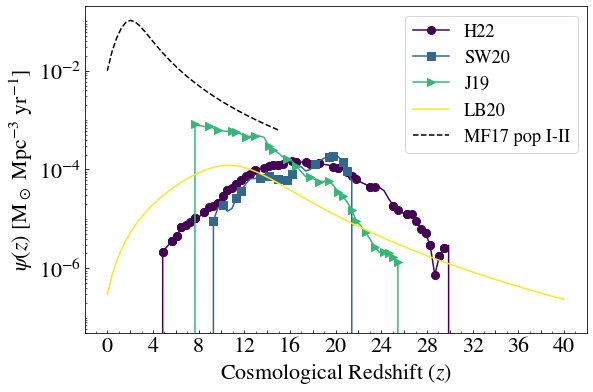

In [8]:
# considered models
#models = ['A-sloth', 'Hartwig16', 'DeSouza', 'Jaacks', 'LiuBromm', 'MandF2017']
models_2 = ['A-sloth_smooth_off','Skinner_smooth_off', #'DeSouza_smooth_off',
            'Jaacks', 'LiuBromm']

models_leg_2 = ['H22', 'SW20',#'dS11',
                'J19', 'LB20']

#pop = 'III'


viridis = cm.get_cmap('viridis', len(models_2))
divid = np.linspace(0, 1,len(models_2))
color_models = viridis(divid) #[::-1]


# let's compare the variosu SFRD 

font_value = 22
#plt.figure(figsize=(9,6))

fig, axs = plt.subplots(1,1,figsize=(9,6),gridspec_kw={
                         'wspace': 0, 'hspace': 0})  

z_sfr = np.linspace(zMAX,zMIN,100)

marker_sfrd = ['o','s','>','<','p']

m = -1
for mod in models_2:
    m += 1
    print(m, mod)
    

    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


        
    if (sfrd_interpol_file == False) and (mod != 'MandF2017'): 
        
        p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    )
        np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        
        
    else:
        
        markers_on  = []
        for tt in range(len(sfr_fromtxt)):
            markers_on.append(np.argmin(abs(sfr_fromtxt[tt]-SFR_array)))
            
            
    
        if at_z_0 == True:
        
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m], linestyle = 'solid',
                    color = color_models[m],
                     marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        


        else:
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
        
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
    
    
                #,color = color_z[m+1])
    #color_p = p[0].get_color()

    #if (sfrd_interpol_file != False) and (mod != 'MandF2017'): 
    #    axs.plot(z_fromtxt, sfr_fromtxt, linewidth = 0, marker = marker_sfrd[m], color = color_p,
    #            markersize = 8)
                    #,label = sfrd_interpol_file)

            
        
    
     

    
def  SFR_at_z(z_form):
    
    sfr_norm_in_f = 1e-2
    
    sfr = sfr_norm_in_f*(1. + z_form)**(2.6) / \
                (1.+((1. + z_form)/3.2)**(6.2))  # Msun yr-1 Mpc-3)
    
    return sfr

ind_z = z_sfr < 15

axs.plot(z_sfr[ind_z], SFR_at_z(z_sfr[ind_z]), color = 'black',
         linestyle = 'dashed',label = 'MF17 pop I-II')        
    

    
axs.set_ylim(bottom = 5e-8, top = 2e-1)
axs.set_xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
axs.set_ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)
axs.set_yscale('log')
#plt.ylim(bottom = 1e-9)
axs.tick_params(axis='both', which='both', labelsize=font_value, direction = 'in')

axs.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40])
axs.set_xticklabels(['0','','4','','8','','12','','16','','20','','24','','28','','32','','36','','40'])


axs.xaxis.set_minor_locator(ticker.MultipleLocator(1))

## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs.yaxis.set_minor_locator(y_minor)
axs.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#axs.plot(-1,1e-20, linewidth = 0, marker = 'o', label = 'Interpolation points', color = 'black')

plt.legend(fontsize = font_value/1.2, ncol = 1, loc = 1)

#ax2 = axs.twiny()
#ax2.tick_params(axis='both', which='both', direction='out',length=0, labelsize = 0)
#l0 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0, marker = 'o', alpha = 1)
#l1 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0)
#ax2.legend((l0,l1),('Interpolation points',''),
#               fontsize=font_value, 
#               loc='upper right', ncol=1)


plt.savefig('SFRD_comparison_SW20.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()

[ 4.515  4.645  4.776  4.91   5.048  5.189  5.333  5.481  5.631  5.786
  5.943  6.106  6.271  6.44   6.614  6.792  6.973  7.159  7.349  7.544
  7.741  7.945  8.155  8.368  8.585  8.81   9.038  9.27   9.511  9.755
 10.    10.26  10.52  10.79  11.07  11.35  11.64  11.93  12.23  12.54
 12.86  13.18  13.51  13.85  14.19  14.55  14.91  15.28  15.66  16.05
 16.45  16.85  17.27  17.7   18.13  18.57  19.03  19.49  19.97  20.45
 20.96  21.48  21.99  22.54  23.08  23.64  24.23  24.81  25.41  26.03
 26.65  27.3   27.97  28.66  29.34  30.05  30.74 ]


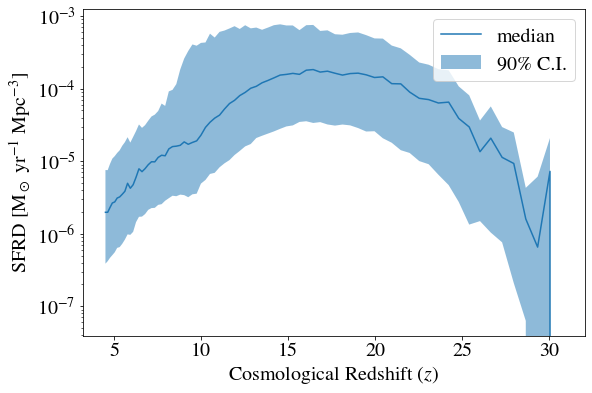

In [9]:
#load data (should be in same folder)
z = np.load("../A-SLOTH_uncrt/SFRD_redshift.npy")
print(z)
SFRD_array = np.load("../A-SLOTH_uncrt/SFRD_arrays.npy")

plt.figure(figsize=(9,6))

font_value = 20

SFRD_mean = []
SFRD_low = []
SFRD_high = []
for i in range(len(z)):
    SFRD_mean.append(np.median(SFRD_array[:,i]))
    SFRD_low.append(np.percentile(SFRD_array[:,i], 2.5))
    SFRD_high.append(np.percentile(SFRD_array[:,i], 97.5))

    
np.savetxt('../asloth_popIII_z_cSFR_median.dat', np.transpose([z, SFRD_mean]))
np.savetxt('../asloth_popIII_z_cSFR_2.5perc.dat', np.transpose([z, SFRD_low]))  
np.savetxt('../asloth_popIII_z_cSFR_97.5perc.dat', np.transpose([z, SFRD_high])) 
    
plt.plot(z, SFRD_mean, label = 'median')

plt.fill_between(z, SFRD_low, SFRD_high, label = '90% C.I.', alpha = 0.5)

plt.ylabel(r'SFRD [M$_\odot$ yr$^{-1}$ Mpc$^{-3}$]', fontsize = font_value)

plt.xlabel(r'Cosmological Redshift ($z$)', fontsize = font_value)

plt.tick_params(axis='both', which='both', labelsize=font_value)

plt.yscale('log')
plt.legend(fontsize = font_value)
plt.show()

0 A-sloth_smooth_off
1 A-sloth_smooth_off_med
2 A-sloth_smooth_off_low
3 A-sloth_smooth_off_high


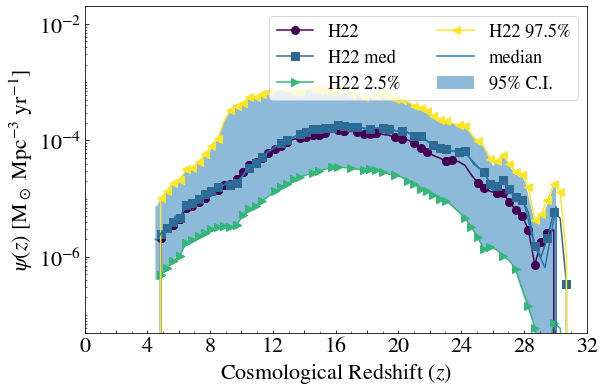

In [10]:

models_2 = ['A-sloth_smooth_off', 'A-sloth_smooth_off_med', 'A-sloth_smooth_off_low', 'A-sloth_smooth_off_high']

models_leg_2 = ['H22', 'H22 med', 'H22 2.5%', 'H22 97.5%']

# let's compare the variosu SFRD 

font_value = 22


fig, axs = plt.subplots(1,1,figsize=(9,6),gridspec_kw={
                         'wspace': 0, 'hspace': 0})  

z_sfr = np.linspace(zMAX,zMIN,100)

marker_sfrd = ['o', 's', '>', '<']

m = -1
for mod in models_2:
    m += 1
    print(m, mod)
    

    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


        
    if (sfrd_interpol_file == False) and (mod != 'MandF2017'): 
        
        p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    )
        np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        
        
    else:
        
        markers_on  = []
        for tt in range(len(sfr_fromtxt)):
            markers_on.append(np.argmin(abs(sfr_fromtxt[tt]-SFR_array)))
            
            
    
        if at_z_0 == True:
        
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m], linestyle = 'solid',
                    color = color_models[m],
                     marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        


        else:
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
        
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
    

plt.plot(z, SFRD_mean, label = 'median')

plt.fill_between(z, SFRD_low, SFRD_high, label = '95% C.I.', alpha = 0.5)



    
axs.set_ylim(bottom = 5e-8, top = 2e-2)
axs.set_xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
axs.set_ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)
axs.set_yscale('log')
#plt.ylim(bottom = 1e-9)
axs.tick_params(axis='both', which='both', labelsize=font_value, direction = 'in')

axs.set_xlim([0,32])
axs.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32])
axs.set_xticklabels(['0','','4','','8','','12','','16','','20','','24','','28','','32'])


axs.xaxis.set_minor_locator(ticker.MultipleLocator(1))

## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs.yaxis.set_minor_locator(y_minor)
axs.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#axs.plot(-1,1e-20, linewidth = 0, marker = 'o', label = 'Interpolation points', color = 'black')

plt.legend(fontsize = font_value/1.2, ncol = 2, loc = 1)

#ax2 = axs.twiny()
#ax2.tick_params(axis='both', which='both', direction='out',length=0, labelsize = 0)
#l0 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0, marker = 'o', alpha = 1)
#l1 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0)
#ax2.legend((l0,l1),('Interpolation points',''),
#               fontsize=font_value, 
#               loc='upper right', ncol=1)


plt.savefig('SFRD_comparison_ASLOTH.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()

0 A-sloth_smooth_off
1 Skinner_smooth_off
2 Jaacks
3 LiuBromm


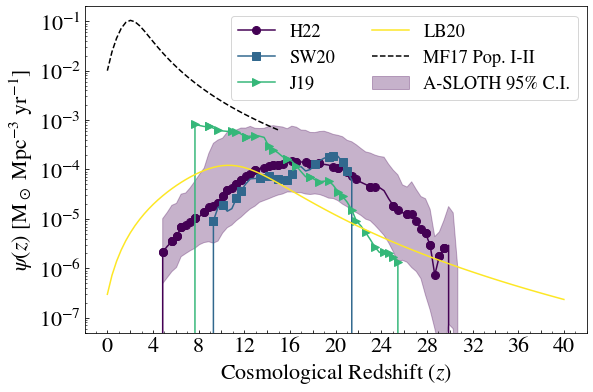

In [11]:
# considered models
#models = ['A-sloth', 'Hartwig16', 'DeSouza', 'Jaacks', 'LiuBromm', 'MandF2017']
models_2 = ['A-sloth_smooth_off',
            'Skinner_smooth_off', #'DeSouza_smooth_off',
            'Jaacks', 'LiuBromm']

models_leg_2 = ['H22', 'SW20',#'dS11',
                'J19', 'LB20']

#pop = 'III'


viridis = cm.get_cmap('viridis', len(models_2))
divid = np.linspace(0, 1,len(models_2))
color_models = viridis(divid) #[::-1]


# let's compare the variosu SFRD 

font_value = 22
#plt.figure(figsize=(9,6))

fig, axs = plt.subplots(1,1,figsize=(9,6),gridspec_kw={
                         'wspace': 0, 'hspace': 0})  

z_sfr = np.linspace(zMAX,zMIN,100)

marker_sfrd = ['o','s','>','<','p']

m = -1
for mod in models_2:
    m += 1
    print(m, mod)
    

    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


        
    if (sfrd_interpol_file == False) and (mod != 'MandF2017'): 
        
        p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    )
        np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        
        
    else:
        
        markers_on  = []
        for tt in range(len(sfr_fromtxt)):
            markers_on.append(np.argmin(abs(sfr_fromtxt[tt]-SFR_array)))
            
            
    
        if at_z_0 == True:
        
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m], linestyle = 'solid',
                    color = color_models[m],
                     marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        


        else:
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
        
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
    
    
                #,color = color_z[m+1])
    #color_p = p[0].get_color()

    #if (sfrd_interpol_file != False) and (mod != 'MandF2017'): 
    #    axs.plot(z_fromtxt, sfr_fromtxt, linewidth = 0, marker = marker_sfrd[m], color = color_p,
    #            markersize = 8)
                    #,label = sfrd_interpol_file)

            
z, SFRD_low = np.loadtxt('SFRD_to_plots/SFRD_A-sloth_smooth_off_low.txt', unpack = True)
z, SFRD_high = np.loadtxt('SFRD_to_plots/SFRD_A-sloth_smooth_off_high.txt', unpack = True)
axs.fill_between(z, SFRD_low, SFRD_high, alpha = 0.3,
                color = color_models[0], label = 'A-SLOTH 95% C.I.')  

    
def  SFR_at_z(z_form):
    
    sfr_norm_in_f = 1e-2
    
    sfr = sfr_norm_in_f*(1. + z_form)**(2.6) / \
                (1.+((1. + z_form)/3.2)**(6.2))  # Msun yr-1 Mpc-3)
    
    return sfr

ind_z = z_sfr < 15

axs.plot(z_sfr[ind_z], SFR_at_z(z_sfr[ind_z]), color = 'black',
         linestyle = 'dashed',label = 'MF17 Pop. I-II')        
    

    
axs.set_ylim(bottom = 5e-8, top = 2e-1)
axs.set_xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
axs.set_ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)


axs.set_yscale('log')
#plt.ylim(bottom = 1e-9)
axs.tick_params(axis='both', which='both', labelsize=font_value, direction = 'in')

axs.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40])
axs.set_xticklabels(['0','','4','','8','','12','','16','','20','','24','','28','','32','','36','','40'])


axs.xaxis.set_minor_locator(ticker.MultipleLocator(1))

## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs.yaxis.set_minor_locator(y_minor)
axs.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

axs.set_yticks([1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2,1e-1])
axs.set_yticklabels([r'$10^{-7}$',r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$',
                    r'$10^{-1}$'])


#axs.plot(-1,1e-20, linewidth = 0, marker = 'o', label = 'Interpolation points', color = 'black')

plt.legend(fontsize = font_value/1.2, ncol = 2
           , loc = 1)

#ax2 = axs.twiny()
#ax2.tick_params(axis='both', which='both', direction='out',length=0, labelsize = 0)
#l0 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0, marker = 'o', alpha = 1)
#l1 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0)
#ax2.legend((l0,l1),('Interpolation points',''),
#               fontsize=font_value, 
#               loc='upper right', ncol=1)


plt.savefig('SFRD_comparison_SW20.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()

0 A-sloth_smooth_off
1 PopII_A-sloth_smooth_off
here


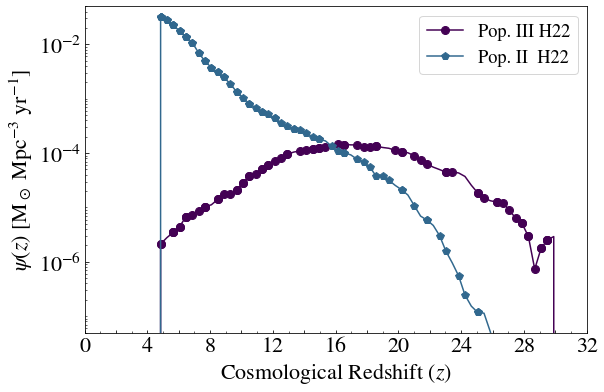

In [12]:

models_2 = ['A-sloth_smooth_off', 'PopII_A-sloth_smooth_off']

models_leg_2 = ['Pop. III H22', 'Pop. II  H22']

# let's compare the variosu SFRD 

font_value = 22


fig, axs = plt.subplots(1,1,figsize=(9,6),gridspec_kw={
                         'wspace': 0, 'hspace': 0})  

z_sfr = np.linspace(zMAX,zMIN,100)

marker_sfrd = ['o', 'p']

m = -1
for mod in models_2:
    m += 1
    print(m, mod)
    

    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


        
    if (sfrd_interpol_file == False) and (mod != 'MandF2017'): 
        
        p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    )
        np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        
        
    else:
        
        markers_on  = []
        for tt in range(len(sfr_fromtxt)):
            markers_on.append(np.argmin(abs(sfr_fromtxt[tt]-SFR_array)))
            
            
    
        if at_z_0 == True:
        
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m], linestyle = 'solid',
                    color = color_models[m],
                     marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
            

                
                


        else:
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            if mod == 'PopII_A-sloth_smooth_off':
                print('here')
                z_popII = np.array(z_sfr)
                SFR_popII = np.array(SFR_array)
                markers_popII = np.array(markers_on)
        
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
    


    
axs.set_ylim(bottom = 5e-8, top = 5e-2)
axs.set_xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
axs.set_ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)
axs.set_yscale('log')
#plt.ylim(bottom = 1e-9)
axs.tick_params(axis='both', which='both', labelsize=font_value, direction = 'in')

axs.set_xlim([0,32])
axs.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32])
axs.set_xticklabels(['0','','4','','8','','12','','16','','20','','24','','28','','32'])


axs.xaxis.set_minor_locator(ticker.MultipleLocator(1))

## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs.yaxis.set_minor_locator(y_minor)
axs.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#axs.plot(-1,1e-20, linewidth = 0, marker = 'o', label = 'Interpolation points', color = 'black')

plt.legend(fontsize = font_value/1.2, ncol = 1, loc = 1)

#ax2 = axs.twiny()
#ax2.tick_params(axis='both', which='both', direction='out',length=0, labelsize = 0)
#l0 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0, marker = 'o', alpha = 1)
#l1 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0)
#ax2.legend((l0,l1),('Interpolation points',''),
#               fontsize=font_value, 
#               loc='upper right', ncol=1)


plt.savefig('SFRD_comparison_PopII_ASLOTH.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()

0 A-sloth_smooth_off
[ 4.515  4.645  4.776  4.91   5.048  5.189  5.333  5.481  5.631  5.786
  5.943  6.106  6.271  6.44   6.614  6.792  6.973  7.159  7.349  7.544
  7.741  7.945  8.155  8.368  8.585  8.81   9.038  9.27   9.511  9.755
 10.    10.26  10.52  10.79  11.07  11.35  11.64  11.93  12.23  12.54
 12.86  13.18  13.51  13.85  14.19  14.55  14.91  15.28  15.66  16.05
 16.45  16.85  17.27  17.7   18.13  18.57  19.03  19.49  19.97  20.45
 20.96  21.48  21.99  22.54  23.08  23.64  24.23  24.81  25.41  26.03
 26.65  27.3   27.97  28.66  29.34  30.05 ] [1.711e-06 1.732e-06 2.003e-06 2.239e-06 2.483e-06 2.625e-06 2.996e-06
 3.293e-06 3.284e-06 4.532e-06 3.844e-06 4.695e-06 5.269e-06 6.804e-06
 6.468e-06 6.933e-06 8.067e-06 8.639e-06 8.848e-06 1.008e-05 1.051e-05
 1.015e-05 1.175e-05 1.386e-05 1.416e-05 1.679e-05 1.834e-05 1.770e-05
 1.929e-05 2.188e-05 2.749e-05 3.058e-05 3.804e-05 4.061e-05 4.415e-05
 5.079e-05 5.909e-05 6.414e-05 7.679e-05 8.086e-05 9.478e-05 9.796e-05
 1.120e-04 1.080

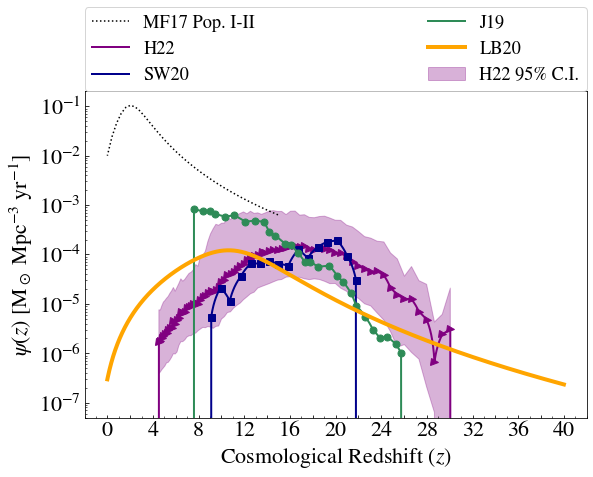

In [13]:
# considered models
#models = ['A-sloth', 'Hartwig16', 'DeSouza', 'Jaacks', 'LiuBromm', 'MandF2017']
models_2 = ['A-sloth_smooth_off',
            'Skinner_smooth_off', #'DeSouza_smooth_off',
            'Jaacks', 'LiuBromm']

models_leg_2 = ['H22', 'SW20',#'dS11',
                'J19', 'LB20']

#pop = 'III'


viridis = cm.get_cmap('viridis', len(models_2))
divid = np.linspace(0, 1,len(models_2))
color_models = viridis(divid) #[::-1]

color_models = ['purple', 'darkblue', 'seagreen', 'orange']

width_mod = [2, 2, 2, 4]


# let's compare the variosu SFRD 

font_value = 22
#plt.figure(figsize=(9,6))

fig, axs = plt.subplots(1,1,figsize=(9,6),gridspec_kw={
                         'wspace': 0, 'hspace': 0})  

def  SFR_at_z(z_form):
    
    sfr_norm_in_f = 1e-2
    
    sfr = sfr_norm_in_f*(1. + z_form)**(2.6) / \
                (1.+((1. + z_form)/3.2)**(6.2))  # Msun yr-1 Mpc-3)
    
    return sfr

ind_z = z_sfr < 15

axs.plot(z_sfr[ind_z], SFR_at_z(z_sfr[ind_z]), color = 'black',
         linestyle = 'dotted',label = 'MF17 Pop. I-II', linewidth = 1.5)        
    


    
#axs.plot(z_popII, SFR_popII, color = 'black',
#         linestyle = 'dashed',label = 'A-SLOTH Pop. II', linewidth = 2.5)     
    
ind_non_zero = SFR_popII > 0
#axs.plot(z_popII, SFR_popII,
#                    label = 'H22 Pop. II',
#                    color = 'grey',
#                    marker = '<',
#                    markevery=markers_popII,
#                    markersize = 8)


z_sfr = np.linspace(zMAX,zMIN,10000)

marker_sfrd = ['>','s','o']#,'<','p']

m = -1
for mod in models_2:
    m += 1
    print(m, mod)
    

    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


        
    if (sfrd_interpol_file == False) and (mod != 'MandF2017'): 
        
        p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                     linewidth = width_mod[m],
                    )
        np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        
        
    else:
        
        markers_on  = []
        for tt in range(len(sfr_fromtxt)):
            #markers_on.append(np.argmin(abs(sfr_fromtxt[tt]-SFR_array)))
            markers_on.append(np.argmin(abs(z_fromtxt[tt]-z_sfr)))
            
            
    
        if at_z_0 == True:
        
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m], linestyle = 'solid',
                    color = color_models[m],
                         linewidth = width_mod[m],
                     #marker = marker_sfrd[m],
                    #markevery=markers_on,
                    #markersize = 8
                        )
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
            
            if mod == 'A-sloth_smooth_off':
                

                
                z, SFRD_low = np.loadtxt('../asloth_popIII_z_cSFR_2.5perc.dat', unpack = True)
                z, SFRD_high = np.loadtxt('../asloth_popIII_z_cSFR_97.5perc.dat', unpack = True)
                axs.fill_between(z, SFRD_low, SFRD_high, alpha = 0.3,
                    color = color_models[0], label = 'H22 95% C.I.')  
        


        else:
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    #marker = marker_sfrd[m],
                         linewidth = width_mod[m],
                    # markevery=markers_on,
                    # markersize = 8
                        )
        
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
    
    
                #,color = color_z[m+1])
    #color_p = p[0].get_color()

    if (sfrd_interpol_file != False) and (mod != 'MandF2017'): 
        axs.plot(z_fromtxt, sfr_fromtxt, linewidth = 0, marker = marker_sfrd[m], color = color_models[m],
                markersize = 7)
        print(z_fromtxt, sfr_fromtxt)
                    #,label = sfrd_interpol_file)


    
axs.set_ylim(bottom = 5e-8, top = 2e-1)
axs.set_xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
axs.set_ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)


axs.set_yscale('log')
#plt.ylim(bottom = 1e-9)
axs.tick_params(axis='both', which='both', labelsize=font_value, direction = 'in')

axs.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40])
axs.set_xticklabels(['0','','4','','8','','12','','16','','20','','24','','28','','32','','36','','40'])


axs.xaxis.set_minor_locator(ticker.MultipleLocator(1))

## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs.yaxis.set_minor_locator(y_minor)
axs.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

axs.set_yticks([1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2,1e-1])
axs.set_yticklabels([r'$10^{-7}$',r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$',
                    r'$10^{-1}$'])


#axs.plot(-1,1e-20, linewidth = 0, marker = 'o', label = 'Interpolation points', color = 'black')

#plt.legend(fontsize = font_value/1.2, ncol = 1
#           , loc = 1)

axs.legend(fontsize=font_value/1.2, ncol=2, bbox_to_anchor=(0, 1.0, 1, 1.3),
               frameon=True, loc=3, mode="expand", borderaxespad=0.)



#ax2 = axs.twiny()
#ax2.tick_params(axis='both', which='both', direction='out',length=0, labelsize = 0)
#l0 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0, marker = 'o', alpha = 1)
#l1 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0)
#ax2.legend((l0,l1),('Interpolation points',''),
#               fontsize=font_value, 
#               loc='upper right', ncol=1)


plt.savefig('SFRD_comparison_SW20.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()

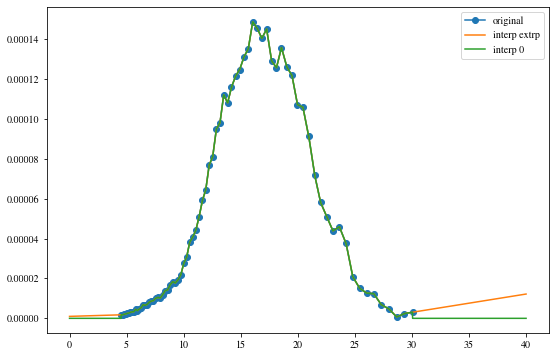

In [14]:
plt.figure(figsize = (9,6))

sfrd_interpol_file_mod = ['../asloth_popIII_z_cSFR.dat'] 

z_fromtxt, sfr_fromtxt = np.genfromtxt(''+sfrd_interpol_file_mod[0], 
                                               dtype='float', unpack=True)



plt.plot(z_fromtxt, sfr_fromtxt, "-o", label = 'original')


z_array = np.linspace(0,40,10000)



SFR_at_z_interp1d =  interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
                                     fill_value='extrapolate')
plt.plot(z_array, SFR_at_z_interp1d(z_array), label = 'interp extrp')


SFR_at_z_interp1d =  interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
                                     fill_value=0)
plt.plot(z_array, SFR_at_z_interp1d(z_array), label = 'interp 0')


#plt.yscale('lin')


plt.legend()

plt.show()


0 Jaacks
1 Jaacks_refined


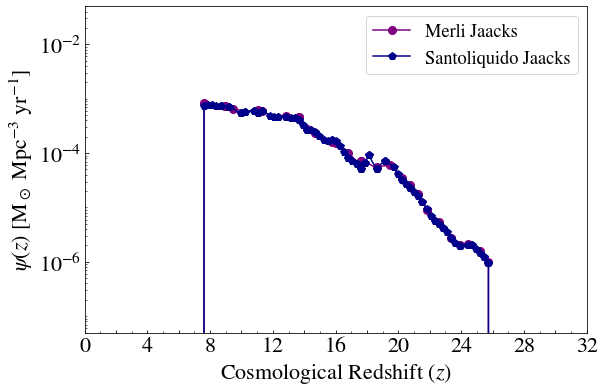

In [16]:

models_2 = ['Jaacks', 'Jaacks_refined']

models_leg_2 = ['Merli Jaacks', 'Santoliquido Jaacks']

# let's compare the variosu SFRD 

font_value = 22


fig, axs = plt.subplots(1,1,figsize=(9,6),gridspec_kw={
                         'wspace': 0, 'hspace': 0})  

z_sfr = np.linspace(26,zMIN,100)

marker_sfrd = ['o', 'p']

m = -1
for mod in models_2:
    m += 1
    print(m, mod)
    

    
    sfrd_interpol_file, at_z_0 = select_SFR_model(mod, pop)
    SFR_eval, sfr_args_chosen, z_fromtxt, sfr_fromtxt = SFR_build(mod, pop, sfrd_interpol_file, at_z_0)
    
    SFR_array = []
    
    for iz in range(len(z_sfr)):
        SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))


        
    if (sfrd_interpol_file == False) and (mod != 'MandF2017'): 
        
        p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    )
        np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
        
        
    else:
        
        markers_on  = []
        for tt in range(len(sfr_fromtxt)):
            markers_on.append(np.argmin(abs(sfr_fromtxt[tt]-SFR_array)))
            
            
    
        if at_z_0 == True:
        
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m], linestyle = 'solid',
                    color = color_models[m],
                     marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
            

                
                


        else:
        
        
            p = axs.plot(z_sfr, SFR_array,
                 label = models_leg_2[m],
                    color = color_models[m],
                    marker = marker_sfrd[m],
                    markevery=markers_on,
                    markersize = 8)
            if mod == 'PopII_A-sloth_smooth_off':
                print('here')
                z_popII = np.array(z_sfr)
                SFR_popII = np.array(SFR_array)
                markers_popII = np.array(markers_on)
        
            np.savetxt('SFRD_to_plots/SFRD_'+mod+'.txt', np.transpose([z_sfr, SFR_array]))
    


    
axs.set_ylim(bottom = 5e-8, top = 5e-2)
axs.set_xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
axs.set_ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)
axs.set_yscale('log')
#plt.ylim(bottom = 1e-9)
axs.tick_params(axis='both', which='both', labelsize=font_value, direction = 'in')

axs.set_xlim([0,32])
axs.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32])
axs.set_xticklabels(['0','','4','','8','','12','','16','','20','','24','','28','','32'])


axs.xaxis.set_minor_locator(ticker.MultipleLocator(1))

## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs.yaxis.set_minor_locator(y_minor)
axs.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#axs.plot(-1,1e-20, linewidth = 0, marker = 'o', label = 'Interpolation points', color = 'black')

plt.legend(fontsize = font_value/1.2, ncol = 1, loc = 1)

#ax2 = axs.twiny()
#ax2.tick_params(axis='both', which='both', direction='out',length=0, labelsize = 0)
#l0 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0, marker = 'o', alpha = 1)
#l1 =  matplotlib.lines.Line2D([0],[0],color="black", linestyle = 'solid',linewidth = 0)
#ax2.legend((l0,l1),('Interpolation points',''),
#               fontsize=font_value, 
#               loc='upper right', ncol=1)


plt.savefig('SFRD_comparison_Jaacks.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
plt.close()